# <center>Соревнование Kaggle "Идентификация пользователей по посещенным веб-страницам"

## Цели и задачи проекта

**В данном проекте решается задача определения конкретного пользователся по посещенным веб-сайтам. Алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).**

## Исходные данные

**Данные представлены на странице соревнования Kaggle** https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.

* в файле "train_sessions.csv" содержится обучающая выборка,
* в файле "test_sessions.csv" содержится тестовая выборка,
* в файле "site_dic.pkl" содержится словарь соответствия индексов и названи сайтов


**В обучающей выборке представлены следующие признаки:**

- site1 – индекс первого посещенного сайта в сессии
- time1 – время посещения первого сайта в сессии
- ...
- site10 – индекс 10-го посещенного сайта в сессии
- time10 – время посещения 10-го сайта в сессии
- user_id – ID пользователя

**Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.**

### Подключение необходимых библиотек и загрузка данных

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import sys
from time import ctime, time
%matplotlib inline
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

**Создадим константы для путей к файлам с выборками.**

In [2]:
PATH_TO_DATA = 'data'
TFIDF_MAX_FEATURES = 100000
TFIDF_NGRAM_RANGE = (1, 5)
SEED = 17
LIMIT_TIMESPAN = 600

path_to_train = os.path.join(PATH_TO_DATA, 'train_sessions.csv')
path_to_test  = os.path.join(PATH_TO_DATA, 'test_sessions.csv')
path_to_site_dict = os.path.join(PATH_TO_DATA, 'site_dic.pkl')

**Настроим внешний вид вывода данных для библиотек `numpy` и `pandas`**

In [3]:
np.set_printoptions(linewidth = 100)
pd.set_option('display.max_columns', 1000)

**Считаем данные из файлов. При этом сразу преобразуем временные признаки в формат `datetime64[ns]`.**

In [4]:
time_features = [f'time{i}' for i in range(1, 11)]
train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=time_features)
test_df  = pd.read_csv(path_to_test, index_col='session_id', parse_dates=time_features)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   site1   82797 non-null  int64         
 1   time1   82797 non-null  datetime64[ns]
 2   site2   81308 non-null  float64       
 3   time2   81308 non-null  datetime64[ns]
 4   site3   80075 non-null  float64       
 5   time3   80075 non-null  datetime64[ns]
 6   site4   79182 non-null  float64       
 7   time4   79182 non-null  datetime64[ns]
 8   site5   78341 non-null  float64       
 9   time5   78341 non-null  datetime64[ns]
 10  site6   77566 non-null  float64       
 11  time6   77566 non-null  datetime64[ns]
 12  site7   76840 non-null  float64       
 13  time7   76840 non-null  datetime64[ns]
 14  site8   76151 non-null  float64       
 15  time8   76151 non-null  datetime64[ns]
 16  site9   75484 non-null  float64       
 17  time9   75484 non-null  datetime64[ns]
 18  site10

**Исходную обучающую выборку необходимо отсортировать по возрастанию времени.**

In [7]:
train_df = train_df.sort_values(by='time1')

In [8]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


**Для удобства работы с посещенными сайтами считаем словарь сайтов с индексами.**

In [9]:
with open(path_to_site_dict, 'rb') as f:
    site2id = pickle.load(f)

# Получим обратное преобразование: индекса сайта в его название
id2site = {v:k for (k, v) in site2id.items()}
# Сайт с индексом "0" назовем "unknown"
id2site[0] = 'unknown'

In [10]:
site_features = ['site%s' % i for i in range(1, 11)]
train_df[site_features] = train_df[site_features].fillna(0).astype('int')
test_df[site_features] = test_df[site_features].fillna(0).astype('int')

In [11]:
for i in range(1, 11):
    train_df[f'site{i}'] = train_df[f'site{i}'].apply(lambda x: id2site[x])
    test_df[f'site{i}'] = test_df[f'site{i}'].apply(lambda x: id2site[x])

**Добавим длительность посещения первых 9-ти сайтов. Длительность для 10-го сайта нам неизвестна**

In [12]:
for i in range(1, 10):
    train_df[f'timespan{i}'] = train_df[f'time{i+1}'] - train_df[f'time{i}']
    train_df[f'timespan{i}'] = train_df[f'timespan{i}'].apply(lambda x: x.seconds)
    
    test_df[f'timespan{i}'] = test_df[f'time{i+1}'] - test_df[f'time{i}']
    test_df[f'timespan{i}'] = test_df[f'timespan{i}'].apply(lambda x: x.seconds)

In [13]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target,timespan1,timespan2,timespan3,timespan4,timespan5,timespan6,timespan7,timespan8,timespan9
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-01-12 08:05:57,safebrowsing-cache.google.com,2013-01-12 08:05:57,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54843,safebrowsing.clients.google.com,2013-01-12 08:37:23,safebrowsing-cache.google.com,2013-01-12 08:37:23,safebrowsing.clients.google.com,2013-01-12 09:07:07,safebrowsing-cache.google.com,2013-01-12 09:07:09,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,unknown,NaT,0,0.0,1784.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
77292,www.apache.org,2013-01-12 08:50:13,www.apache.org,2013-01-12 08:50:14,download.eclipse.org,2013-01-12 08:50:15,www.apache.org,2013-01-12 08:50:15,www.apache.org,2013-01-12 08:50:16,www.webtide.com,2013-01-12 08:50:16,download.oracle.com,2013-01-12 08:50:16,javadl-esd-secure.oracle.com,2013-01-12 08:50:16,www.caucho.com,2013-01-12 08:50:17,www.apache.org,2013-01-12 08:50:17,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
114021,www.webtide.com,2013-01-12 08:50:17,download.oracle.com,2013-01-12 08:50:17,www.caucho.com,2013-01-12 08:50:18,download.oracle.com,2013-01-12 08:50:18,www.webtide.com,2013-01-12 08:50:18,www.apache.org,2013-01-12 08:50:18,public.dhe.ibm.com,2013-01-12 08:50:19,www.webtide.com,2013-01-12 08:50:19,www.apache.org,2013-01-12 08:50:19,www.apache.org,2013-01-12 08:50:20,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
146670,public.dhe.ibm.com,2013-01-12 08:50:20,jope.ow2.org,2013-01-12 08:50:20,download.oracle.com,2013-01-12 08:50:20,public.dhe.ibm.com,2013-01-12 08:50:21,jope.ow2.org,2013-01-12 08:50:21,master.dl.sourceforge.net,2013-01-12 08:50:21,www.apache.org,2013-01-12 08:50:21,download.eclipse.org,2013-01-12 08:50:22,www.apache.org,2013-01-12 08:50:22,public.dhe.ibm.com,2013-01-12 08:50:22,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


**Добавим признак "Сайт с наибольшей длительностью посещения". При этом длительность должна превышать значение LIMIT_TIMESPAN. Смысл в том, чтобы указать сайт на котором пользователь провел достаточно долгое время (больше 10 минут)**

In [14]:
timespans_feature_list = [f'timespan{i}' for i in range(1, 10)]

In [15]:
def get_site_with_max_timespan(row):
    idxmax = row.loc[timespans_feature_list].astype(float).idxmax(skipna=True)
    if pd.isnull(idxmax):
        result = 'None'
    else:
        result = row.loc[f'site{idxmax[-1]}'] if row.loc[idxmax] > LIMIT_TIMESPAN else 'None'
    return result

In [16]:
%%time
train_df['site_with_max_timespan'] = train_df.apply(get_site_with_max_timespan, axis=1)
test_df['site_with_max_timespan'] = test_df.apply(get_site_with_max_timespan, axis=1)

Wall time: 6min 54s


**Для удобства разделим имещиеся данные на выборку с сайтами (`train_sites` для обучения, `test_sites` для теста) и выборку с временными параметрами (`train_times` для обучения, `test_times` для теста). Ответы на обучающей выборке поместим в отдельный массив `y_train`.**

In [17]:
tfidf_features = ['site%s' % i for i in range(1, 11)]

train_tfidf_df = train_df[tfidf_features]
test_tfidf_df  = test_df[tfidf_features]

train_times_df = train_df[time_features+['site_with_max_timespan']]
test_times_df  = test_df[time_features+['site_with_max_timespan']]

y_train = train_df['target'].astype('int').values

In [18]:
train_times_df.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,site_with_max_timespan
session_id,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,None
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT,safebrowsing-cache.google.com
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17,None
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20,None
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22,None


In [19]:
test_tfidf_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,www.facebook.com,s-static.ak.facebook.com,apis.google.com,c1.adform.net,www.google.com,mpp2.vindicosuite.com,api.nanigans.com,www.google.fr,secure.vistaprint.fr,www.vistaprint.fr
2,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org
3,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,safebrowsing-cache.google.com,o2i.univ-bpclermont.fr,o2i.univ-bpclermont.fr
4,fr.yahoo.com,yahoo.fr,ocsp.verisign.com,ocsp.thawte.com,rapidssl-ocsp.geotrust.com,clicks.beap.bc.yahoo.com,ocsp.verisign.com,ocsp.digicert.com,ocsp.digicert.com,clicks.beap.bc.yahoo.com
5,sci.sciences.univ-bpclermont.fr,sci.sciences.univ-bpclermont.fr,sci.sciences.univ-bpclermont.fr,go.microsoft.com,windows.microsoft.com,res2.windows.microsoft.com,res1.windows.microsoft.com,ajax.microsoft.com,js.microsoft.com,www.bing.com


### Работа с посещенными сайтами

**Для обработки данных по посещенным сайтом воспользуемся классом `TfidfVectorizer`.
Преобразуем данные в формат, удобный для TfidfVectorizer. Создадим списки посещенных сайтов из названий сайтов**

In [20]:
train_tfidf_list = train_tfidf_df.apply(lambda row: ' '.join(i for i in row), axis=1).tolist()
test_tfidf_list  = test_tfidf_df.apply(lambda row: ' '.join(i for i in row), axis=1).tolist()

In [21]:
for i in [0, 1, 2]:
    print(train_tfidf_list[i], '\n')

safebrowsing.clients.google.com safebrowsing-cache.google.com unknown unknown unknown unknown unknown unknown unknown unknown 

safebrowsing.clients.google.com safebrowsing-cache.google.com safebrowsing.clients.google.com safebrowsing-cache.google.com unknown unknown unknown unknown unknown unknown 

www.apache.org www.apache.org download.eclipse.org www.apache.org www.apache.org www.webtide.com download.oracle.com javadl-esd-secure.oracle.com www.caucho.com www.apache.org 



**Создаем словарь с параметрами `TfidfVectorizer`. Разделять слова будем по пробелам.**

In [22]:
vectorizer_params={'ngram_range': TFIDF_NGRAM_RANGE, 
                   'max_features': TFIDF_MAX_FEATURES,
                   'tokenizer': lambda s: s.split()}

vectorizer = TfidfVectorizer(**vectorizer_params)

**Применим `TfidfVectorizer` к данным и сохранмим результаты в две выборки (`X_train_sites` для обучения, `X_test_sites` для теста).**

In [23]:
X_train_tfidf = vectorizer.fit_transform(train_tfidf_list)
X_test_tfidf  = vectorizer.transform(test_tfidf_list)

In [24]:
X_train_tfidf.shape

(253561, 100000)

**В дополнение к результатм `TfidfVectorizer` cформируем еще признак "количество уникальных посещенных сайтов"**

In [25]:
train_num_unique_sites = train_tfidf_df.nunique(axis=1).values.reshape(-1, 1)
test_num_unique_sites = test_tfidf_df.nunique(axis=1).values.reshape(-1, 1)

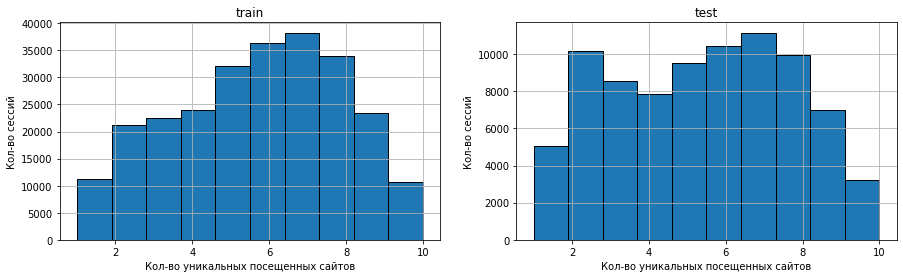

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].hist(train_num_unique_sites, edgecolor='black')
ax[0].set_title('train')
ax[0].set_ylabel('Кол-во сессий')
ax[0].set_xlabel('Кол-во уникальных посещенных сайтов')
ax[0].grid()

ax[1].hist(test_num_unique_sites, edgecolor='black')
ax[1].set_title('test')
ax[1].set_ylabel('Кол-во сессий')
ax[1].set_xlabel('Кол-во уникальных посещенных сайтов')
ax[1].grid()

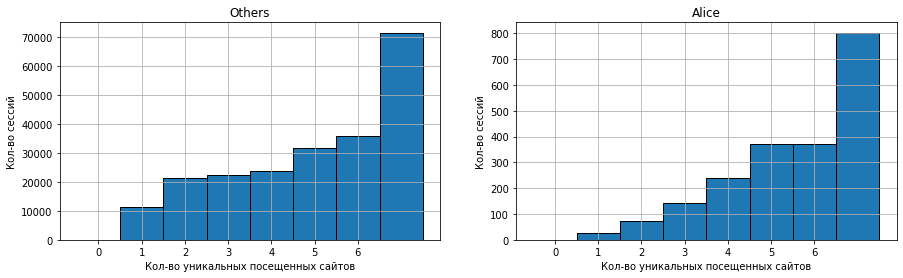

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

for i in [0, 1]:
    ax[i].hist(train_num_unique_sites[y_train == i], edgecolor='black', bins=range(0, 9), align='left')
    ax[i].set_title('Others' if i == 0 else 'Alice')
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('Кол-во уникальных посещенных сайтов')
    ax[i].set_xticks(range(0, 7))
    ax[i].grid()

### Работа с временными признаками

**В исходной обучающей выборке даны времена посещения каждого сайта. Добавим следующие признаки:**
* `min` - временная метка начала сессии,
* `max` - временная метка окончания сессии,
* `hour` - час начала сессии,
* `day_of_week` - день недели начала сессии,
* `month` - месяц начала сессии,
* `all_duration` - продолжительность сессии в секундах.
* `avg_duration` - средняя продолжительность посещения сайта в сессии в секундах.

In [28]:
def time_features_general(time_data_df):
    df = pd.DataFrame()
    df['min'] = time_data_df[time_features].min(axis=1)
    df['max'] = time_data_df[time_features].max(axis=1)

    df['minute']        = df['min'].dt.minute                 # Минута начала сессии
    df['hour']        = df['min'].dt.hour                     # Час начала сессии
    df['day_of_week'] = df['min'].dt.dayofweek                # День начала сессии (0..6)
    df['day_of_month']      = df['min'].dt.day                # Число месяца начала сессии
    df['month']       = df['min'].dt.month                    # Месяц начала сессии (1..12)
    df['year']        = df['min'].dt.year                     # Год начала сессии
    df['all_duration']= (df['max'] - df['min']).dt.seconds    # Продолжительность сессии в секундах
    
    df['site_with_max_timespan'] = time_data_df['site_with_max_timespan']
    
    return df

In [29]:
X_train_times = time_features_general(train_times_df)
X_test_times  = time_features_general(test_times_df)

print(X_train_times.shape)
print(X_test_times.shape)

(253561, 10)
(82797, 10)


**Признак `all_duration` необходимо отмасштабировать.**

In [30]:
duration_scaler = StandardScaler()

X_train_times['all_duration'] = duration_scaler.fit_transform(X_train_times['all_duration'].values.reshape(-1, 1))
X_test_times['all_duration'] = duration_scaler.transform(X_test_times['all_duration'].values.reshape(-1, 1))

In [31]:
X_train_times.head()

,min,max,minute,hour,day_of_week,day_of_month,month,year,all_duration,site_with_max_timespan
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,5,8,5,12,1,2013,-0.468233,None
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,37,8,5,12,1,2013,5.570015,safebrowsing-cache.google.com
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,50,8,5,12,1,2013,-0.454709,None
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,50,8,5,12,1,2013,-0.458090,None
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,50,8,5,12,1,2013,-0.461471,None


**Если обратить внимание на минимальное и максимальное время сессии в обучающей и тестовой выборках, то увидим, что выборки даны за два года (2013 и 2014), причем данные из тестовой выборки следуют по временной шкале сразу за обучающей выборкой.**

In [32]:
print(X_train_times['min'].min())
print(X_train_times['min'].max())
print(X_test_times['min'].min())
print(X_test_times['min'].max())

2013-01-12 08:05:57
2014-04-30 23:39:53
2014-05-01 17:14:03
2014-12-05 23:26:53


**Для оценки модели стоит делать кросс-валидацию по интервалам времени с помощью объекта `TimeSeriesSplit`.**

In [33]:
time_split = TimeSeriesSplit(n_splits=10)

**Далее проведем анализ созданных признаков.**

**Для удобства анализа выделим в отдельные группы сессии, принадлежащие Элис, и сессии, принадлежащие другим людям.**

In [34]:
# Сессии Alice
X_data_Alice = X_train_times[y_train == 1]
print('Alice:', X_data_Alice.shape)

# Сессии других людей
X_data_others = X_train_times[y_train == 0]
print('Others:', X_data_others.shape)

# Создадим словари с данными и подписями для построения графиков
data = {0:X_data_others, 1:X_data_Alice}
title = {0:'Others', 1:'Alice'}

Alice: (2297, 10)
Others: (251264, 10)


**Построим гистограммы распределений чисел месяца начала сессии (`day_of_month`) для сессий, принадлежащих Элис, и для сессий, принадлежащих другим пользователям.**

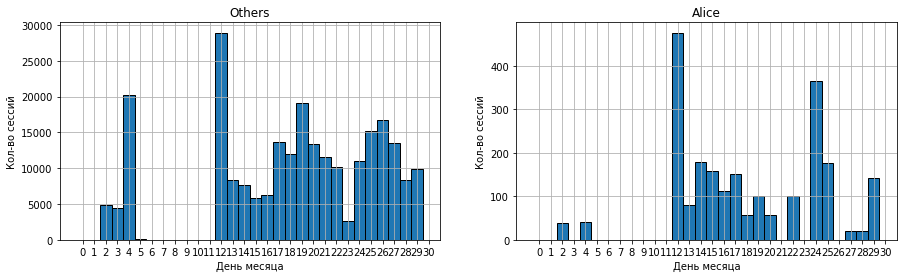

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

for i in [0, 1]:
    ax[i].hist(data[i]['day_of_month'], edgecolor='black', bins=range(0, 31), align='left')
    ax[i].set_title(title[i])
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('Число месяца')
    ax[i].set_xticks(range(0, 31))
    ax[i].grid()

**Если добавить признак число месяца в модель, то модель переобучится, так как ухудшится score при посылке на kaggle. Видимо, нет закономерности в том какое число на календаре. Но на данных Элис видим, что 3,21,23,26 числа нет сессий Элис, возможно на тесте такая закономерность повторяется. Имеет смысл сделать признак, что сессия началась в эти даты (3,21,23,26). Посылка на kaggle подтверждает эту гипотезу, score заметно вырос**

**Построим гистограммы распределений числа месяца начала сессии (`day_of_week`) для train и test.**

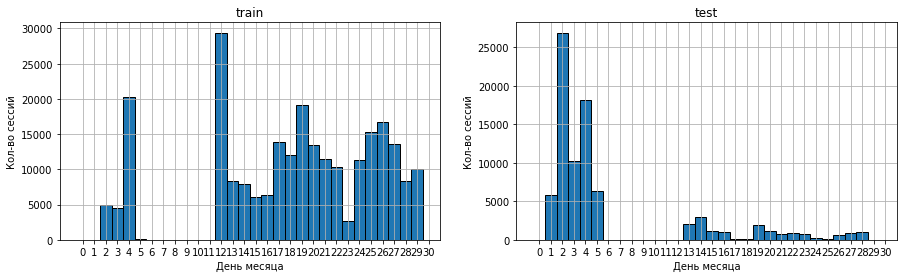

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].hist(X_train_times['day_of_month'], edgecolor='black', bins=range(0, 31), align='left')
ax[0].set_title('train')
ax[0].set_ylabel('Кол-во сессий')
ax[0].set_xlabel('День месяца')
ax[0].set_xticks(range(0, 31))
ax[0].grid()

ax[1].hist(X_test_times['day_of_month'], edgecolor='black', bins=range(0, 31), align='left')
ax[1].set_title('test')
ax[1].set_ylabel('Кол-во сессий')
ax[1].set_xlabel('День месяца')
ax[1].set_xticks(range(0, 31))
ax[1].grid()

**Построим гистограммы распределений дня недели начала сессии (`day_of_week`) для сессий, принадлежащих Элис, и для сессий, принадлежащих другим пользователям.**

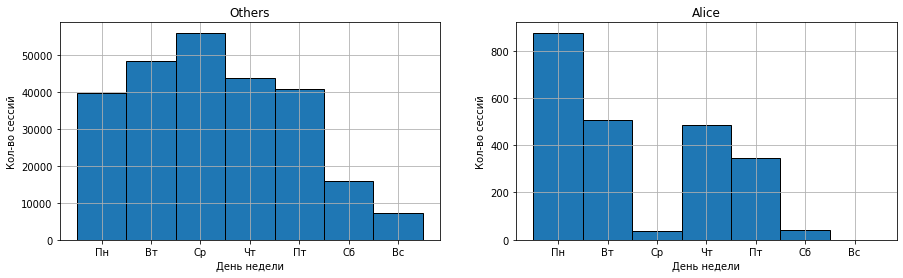

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

for i in [0, 1]:
    ax[i].hist(data[i]['day_of_week'], edgecolor='black', bins=range(0, 8), align='left')
    ax[i].set_title(title[i])
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('День недели')
    ax[i].set_xticks(range(0, 7))
    ax[i].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax[i].grid()

**Видим, что у Элис есть дни, в которые она более активна в сети (Пн, Вт, Чт, Пт), а есть дни, в которые она менее активна (Ср, Сб, Вс). Данный признак (`day_of_week`) стоит добавить в итоговую модель.**

**Построим гистограммы распределений часа начала сессии (`hour`) для сессий, принадлежащих Элис, и для сессий, принадлежащих другим пользователям.**

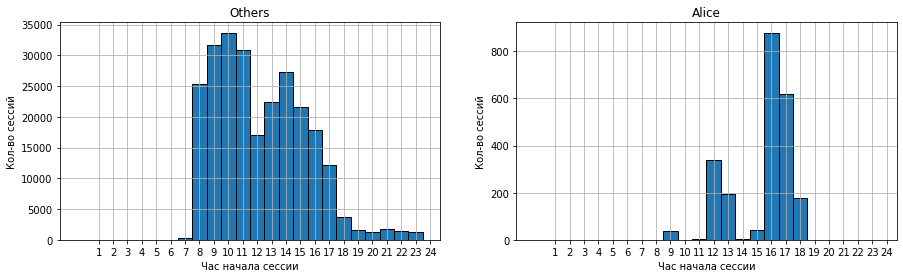

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

for i in [0, 1]:
    ax[i].hist(data[i]['hour'], edgecolor='black', bins=range(0, 25), align='left')
    ax[i].set_title(title[i])
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('Час начала сессии')
    ax[i].set_xticks(range(1, 25))
    ax[i].grid()

**Видим, что у всех пользователей (в том числе и у Элис) отсутствует активность в сети с 0 часов ночи до 6 часов утра. У Элис также наблюдаются периоды активности и бездействия в сети. Удобно будет разбить выборку на интервалы времени по посещенным часам: утро (`morning`), день (`day`) и вечер (`evening`).**

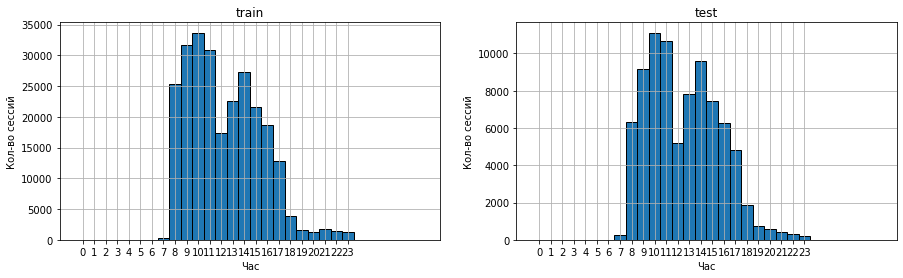

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].hist(X_train_times['hour'], edgecolor='black', bins=range(0, 31), align='left')
ax[0].set_title('train')
ax[0].set_ylabel('Кол-во сессий')
ax[0].set_xlabel('Час')
ax[0].set_xticks(range(0, 24))
ax[0].grid()

ax[1].hist(X_test_times['hour'], edgecolor='black', bins=range(0, 31), align='left')
ax[1].set_title('test')
ax[1].set_ylabel('Кол-во сессий')
ax[1].set_xlabel('Час')
ax[1].set_xticks(range(0, 24))
ax[1].grid()

**Построим гистограммы распределений месяца начала сессии (`month`) для сессий, принадлежащих Элис, и для сессий, принадлежащих другим пользователям.**

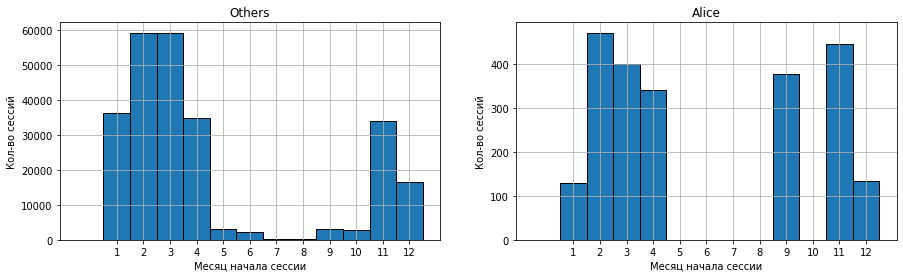

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

for i in [0, 1]:
    ax[i].hist(data[i]['month'], edgecolor='black', bins=range(0, 14), align='left')
    ax[i].set_title(title[i])
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('Месяц начала сессии')
    ax[i].set_xticks(range(1, 13))
    ax[i].grid()

**Видим, что есть существенные различия между Элис и остальными пользователями. Казалось бы, что это информативный признак. Но давайте посмотрим чем отличаются рапределения признака month в train и test.**

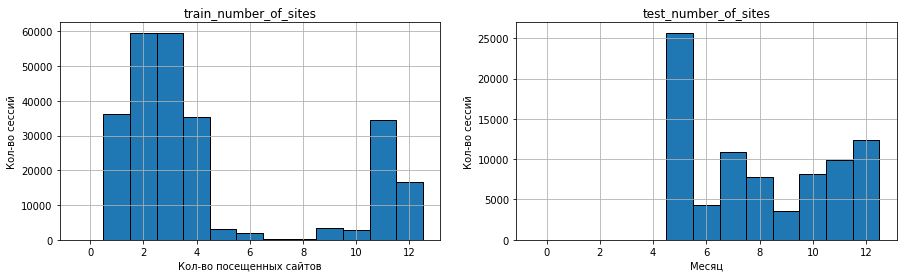

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].hist(X_train_times['month'], bins=range(0, 14), edgecolor='black', align='left')
ax[0].set_title('train_number_of_sites')
ax[0].set_ylabel('Кол-во сессий')
ax[0].set_xlabel('Кол-во посещенных сайтов')
ax[0].grid()

ax[1].hist(X_test_times['month'], bins=range(0, 14), edgecolor='black', align='left')
ax[1].set_title('test_number_of_sites')
ax[1].set_ylabel('Кол-во сессий')
ax[1].set_xlabel('Месяц')
ax[1].grid()

**Видим, что предсказывать нужно в том числе и в месяцы (май-октябрь), когда и у Элис и у остальных пользоватлей в выборке train практически не было активности. То есть использование признака month повлечет переобучение модели, что подтверждается предсказанием на лидерборде Kaggle - при исключении признакак month, оценка повысилась на 0.003, но имеет смысл добавить признаки, когда у Элис не было сессий (лето и октябрь), так как есть подозрения, что на тесте в эти месяцы у Элис так же не было сессий**

**Построим гистограммы распределений минуты начала сессии (`minute`) для сессий, принадлежащих Элис, и для сессий, принадлежащих другим пользователям.**

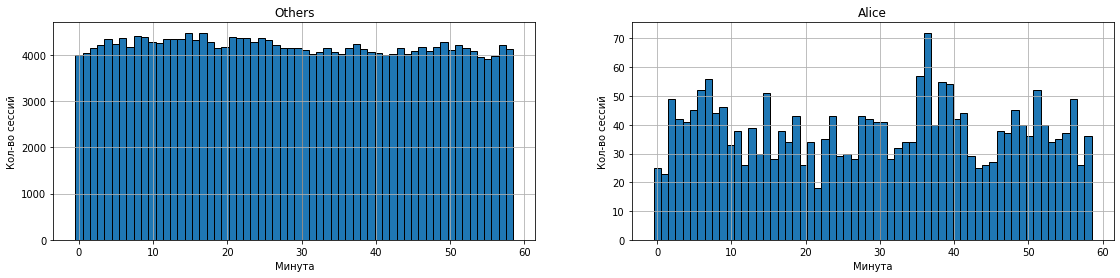

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(19, 4))

for i in [0, 1]:
    ax[i].hist(data[i]['minute'], edgecolor='black', bins=60, align='left')
    ax[i].set_title(title[i])
    ax[i].set_ylabel('Кол-во сессий')
    ax[i].set_xlabel('Минута')
#    ax[i].set_xticks(range(0, 7))
#     ax[i].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax[i].grid()

**Особых закономерностей не наблюдается, но попробуем выделить периоды, в которых среднее значение в выборке Элис отличается от среднего по всей выборке Элис, например с 12 по 34 минуты**

## Добавление новых признаков и построение итоговой модели

In [43]:
def time_features_additional(df):
#    df['0_11_minute'] = ((df['minute'] >=  0) & (df['minute'] <= 11)).astype('int')
    df['12_34_minute'] = ((df['minute'] >=  12) & (df['minute'] <= 34)).astype('int')
    df['35_60_minute'] = ((df['minute'] >=  35) & (df['minute'] <= 60)).astype('int')
    df['hour_7'] = (df['hour'] == 7).astype('int')
    df['hour_8'] = (df['hour'] == 8).astype('int')
    df['hour_9'] = (df['hour'] == 9).astype('int')
    df['hour_10'] = (df['hour'] == 10).astype('int')
    df['hour_11'] = (df['hour'] == 11).astype('int')
    df['hour_12'] = (df['hour'] == 12).astype('int')
    df['hour_14'] = (df['hour'] == 14).astype('int')
    df['hour_15'] = (df['hour'] == 15).astype('int')
    df['hour_17'] = (df['hour'] == 17).astype('int')
    df['morning'] = ((df['hour'] >=  7) & (df['hour'] <= 11)).astype('int')
#    df['day']     = ((df['hour'] >= 12) & (df['hour'] <= 18)).astype('int')
    df['evening'] = ((df['hour'] >= 19) & (df['hour'] <= 23)).astype('int')  
    df['day_out'] = (df['day_of_month'].isin([3,21,23,26])).astype('int')
    df['summer'] = ((( 6 <= df['month']) & (df['month'] <= 8)) | (df['month'] == 10)).astype('int')
    df['november'] = (df['month'] == 11).astype('int')
    df['december'] = (df['month'] == 12).astype('int')
    
    return df

In [44]:
X_train_times = time_features_additional(X_train_times)
X_test_times  = time_features_additional(X_test_times)

In [45]:
X_train_times.head()

,min,max,minute,hour,day_of_week,day_of_month,month,year,all_duration,site_with_max_timespan,0_11_minute,12_34_minute,35_60_minute,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_14,hour_15,hour_17,morning,evening,day_out,summer,november,december
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,5,8,5,12,1,2013,-0.468233,None,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,37,8,5,12,1,2013,5.570015,safebrowsing-cache.google.com,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,50,8,5,12,1,2013,-0.454709,None,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,50,8,5,12,1,2013,-0.458090,None,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,50,8,5,12,1,2013,-0.461471,None,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


**Формируем итоговые обучающую и тестовую выборки**

**One-Hot Encoding**

In [46]:
oh_time_features = ['day_of_week',
                    'year',
                    'site_with_max_timespan'
                   ]

In [47]:
categories = []
categories.append(list(X_train_times['day_of_week'].unique()))
categories.append(list(X_train_times['year'].unique()))
categories.append(
    list(X_train_times['site_with_max_timespan'].unique()) + list(X_test_times['site_with_max_timespan'].unique()))

In [48]:
onehot_encoder = OneHotEncoder(sparse=False, categories=categories)
X_train_oh_encoded = onehot_encoder.fit_transform(X_train_times[oh_time_features].values)
X_test_oh_encoded = onehot_encoder.transform(X_test_times[oh_time_features].values)

In [49]:
X_train_oh_encoded.shape

(253561, 1369)

In [50]:
derivative_time_features = ['morning',
                            '12_34_minute',
                            '35_60_minute',  
                            'evening',
                            'hour_7',
                            'hour_8',
                            'hour_9',
                            'hour_10',
                            'hour_11',
                            'hour_12',
                            'hour_14',
                            'hour_15',
                            'hour_17',
                            'day_out',
                            'all_duration',
                            'november',
                            'december',                            
                            'summer']

X_train_final = hstack([X_train_tfidf, 
                        X_train_times[derivative_time_features].values,
                        X_train_oh_encoded,
                        train_num_unique_sites])
X_test_final = hstack([X_test_tfidf, 
                       X_test_times[derivative_time_features].values,
                       X_test_oh_encoded,
                       test_num_unique_sites])

## Формирование модели

**Будем работать с логистической регрессией. Так как классы сильно несбалансированы, в качестве метрики в данной задаче выбрана ROC-AUC.**

In [51]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

**Посмотрим на оценку метрики на кросс-валидации по времени**

In [52]:
cv_scores = cross_val_score(logit, X_train_final, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

print('CV scores:', cv_scores.round(5))
print()
print('CV mean: {}, CV std: {}'.format(cv_scores.mean().round(5), cv_scores.std().round(5)))

CV scores: [0.81352 0.89666 0.94141 0.95532 0.95415 0.97937 0.90166 0.98134 0.8429  0.97701]

CV mean: 0.92433, CV std: 0.05603


**Попробуем улучшить качество модели с помощью поиска по сетке. Подберем значение параметра `C` для логистической регрессии.**

In [53]:
c_values = np.logspace(-2, 2, 10)
c_values

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01, 5.99484250e-01,
       1.66810054e+00, 4.64158883e+00, 1.29154967e+01, 3.59381366e+01, 1.00000000e+02])

In [54]:
logit_cv = LogisticRegressionCV(Cs = c_values,
                                multi_class = 'ovr',
                                random_state = SEED,
                                cv = time_split,
                                scoring='roc_auc',
                                verbose=1,
                                solver='liblinear',
                                n_jobs=-1)
logit_cv.fit(X_train_final, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.6min finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01, 5.99484250e-01,
       1.66810054e+00, 4.64158883e+00, 1.29154967e+01, 3.59381366e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True,
                     scoring='roc_auc', solver='liblinear', tol=0.0001,
                     verbose=1)

In [55]:
logit_mean_cv_scores = logit_cv.scores_[1].mean(axis=0)
logit_mean_cv_scores

# лучшее значение ROC-AUC на кросс-валидации
max_score = logit_mean_cv_scores.max()
print('max_score =', max_score)

# соответствующее значение C
best_C = logit_cv.Cs_[logit_mean_cv_scores.argmax()]

print('best C =', best_C)

max_score = 0.9305929082498826
best C = 12.915496650148826


## Формирование итогового предсказания

In [56]:
#used_C = 1.6681005372
used_C = best_C

In [57]:
logit_final = LogisticRegression(C=used_C, random_state=SEED, solver='liblinear')
logit_final.fit(X_train_final, y_train)

LogisticRegression(C=12.915496650148826, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
predicted_labels = logit_final.predict_proba(X_test_final)[:, 1]

**Сохраняем результат в файл**

In [59]:
predicted_df = pd.DataFrame(predicted_labels,
                            index = np.arange(1, predicted_labels.shape[0] + 1),
                            columns=['target'])

predicted_df.to_csv(r'submissions/submission_final.csv', index_label='session_id')

In [60]:
with open('results.txt', 'a') as f:
    f.write(f'{ctime(time())}\n')
    f.write(f'LIMIT_TIMESPAN: {LIMIT_TIMESPAN}\n')
    f.write(f'TFIDF_MAX_FEATURES: {TFIDF_MAX_FEATURES}\n')
    f.write(f'TFIDF_NGRAM_RANGE: {TFIDF_NGRAM_RANGE}\n')
    f.write(f'oh_time_features {oh_time_features}\n')
    f.write(f'derivative_time_features {derivative_time_features}\n')
    f.write(f'CV scores: {cv_scores.round(5)}\n')
    f.write(f'CV mean: {cv_scores.mean().round(5)}, CV std: {cv_scores.std().round(5)}\n')
    f.write(f'max_score = {max_score}\n')
    f.write(f'best_C = {best_C}\n')
    f.write(f'used_C = {used_C}\n\n')


In [61]:
assert 1==2

AssertionError: 